In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import pickle
import cv2

In [21]:
from importlib import reload
from sln import utils; reload(utils)
from sln import train; reload(train)

<module 'sln.train' from 'D:\\side\\CarND-Vehicle-Detection\\sln\\train.py'>

In [10]:
svc = pickle.load( open("svc.p", "rb" ))

In [11]:
vehicles = utils.load_array('vehicles/')
non_vehicles = utils.load_array('non_vehicles/')

In [37]:
img = mpimg.imread('test_images/test4.jpg')

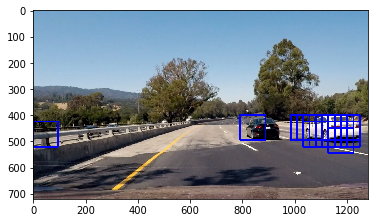

In [38]:
def find_cars(img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block):
    draw_img = np.copy(img)
    img_tosearch = img[ystart:ystop,:,:]
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    gray = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2GRAY)

    # Define blocks and steps as above
    nxblocks = (gray.shape[1] // pix_per_cell)-1
    nyblocks = (gray.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    all_hog = train.get_hog_features(gray, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat = all_hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            test_features = train.combine_feat(hog_feat, subimg)
            test_features = test_features.reshape(1,-1)
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
orient = 9
pix_per_cell = 8
cell_per_block = 2
    
out_img = find_cars(img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block)

plt.imshow(out_img)